# Regression

In this notebook, we calculate the Swiss Army infinitsimal jackknife error bounds for linear regression.

This example illustrates at least one way in which dimension dependence can occur implicitly in the error bound of Theorem 1.

In [30]:
import autograd
import autograd.numpy as np
import scipy as sp
import paragami
import vittles

from tqdm import tqdm 
import pandas as pd
import time
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
# A convenience function to visually compare two variables.
def comparison_plot(x, y):
    plt.plot(x, x, "k")
    plt.plot(x, y, "r.")
    plt.show()

## Generate data and calculate IJ.

First, generate some data according to a linear regression model.

In [72]:
N = 20000
data = pd.read_csv("train.csv").iloc[:N].sort_values(by="total_fare")
x, y = data.drop(columns=["total_fare"]).values, data["total_fare"].values
x = MinMaxScaler().fit_transform(x)
dim = x.shape[1]
num_obs = len(y)
print(num_obs)
theta_true = LinearRegression().fit(x, y).coef_
theta_true

20000


array([9.47656276e-13, 9.09494702e-13, 1.96953565e-13, 1.65750000e+03,
       9.50000000e+02, 2.30875000e+02, 5.68434189e-14])

First, we specify the weighted regression loss function.  In this case, the optimum is available in closed form.  For convenience we implement the closed form optimum and test that it matches the optimum of the loss function.

In [79]:
def eval_log_loss(theta, w, x, y):
    resid = y - x @ theta
    log_lik = -0.5 * np.sum(w * (resid**2)) / num_obs
    return -1 * log_lik


def get_optimum(w, x, y):
    xtx = (w[:, None] * x).T @ x
    xty = (w[:, None] * x).T @ y
    return np.linalg.solve(xtx, xty)


# Test the loss function and optimum with random weights.
w = np.ones(num_obs) + 1 * (np.random.random(num_obs) - 0.5)

log_loss_objective = paragami.OptimizationObjective(
    lambda theta: eval_log_loss(theta, w, x, y)
)

theta_guess = np.zeros(dim)

opt = sp.optimize.minimize(
    fun=log_loss_objective.f,
    jac=log_loss_objective.grad,
    hess=log_loss_objective.hessian,
    method="trust-exact",
    x0=theta_guess,
    options={"gtol": 1e-12},
)
print(opt.message)

# assert(np.linalg.norm(opt.x - get_optimum(w, x, y)) / dim < 1e-8)

Iter 0: f = 12426.59726406
Iter 1: f = 12371.66664015
Iter 2: f = 12262.71926921
Iter 3: f = 12048.54270792
Iter 4: f = 11634.97368601
Iter 5: f = 10864.45010850
Iter 6: f = 9527.03751339
Iter 7: f = 7505.47369661
Iter 8: f = 5231.93107664
Iter 9: f = 3031.41401800
Iter 10: f = 787.48559800
Iter 11: f = 17.77385009
Iter 12: f = 0.00000000
Optimization terminated successfully.


Get the initial optimum at the vector of unity weights.

In [76]:
w1 = np.ones(num_obs)
theta_opt = get_optimum(w1, x, y)

Define an IJ predictor using ``vittles``.

In [77]:
ij_predictor = vittles.HyperparameterSensitivityLinearApproximation(
    lambda theta, w: eval_log_loss(theta, w, x, y),
    opt_par_value=theta_opt,
    hyper_par_value=w1,
)

Get the IJ predictions and exact CV for a range of weights.

100%|██████████| 20000/20000 [00:14<00:00, 1406.49it/s]


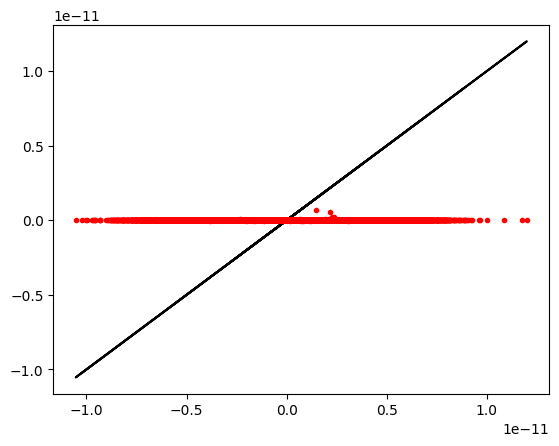

In [78]:
theta_ij = np.full((num_obs, dim), float("nan"))
theta_cv = np.full((num_obs, dim), float("nan"))

ij_time = 0
cv_time = 0

w_loo = np.ones(num_obs)
for n in tqdm(range(num_obs)):
    w_loo[n] = 0
    tic = time.time()
    theta_ij[n, :] = ij_predictor.predict_opt_par_from_hyper_par(w_loo)
    ij_time = ij_time + time.time() - tic

    tic = time.time()
    theta_cv[n, :] = get_optimum(w_loo, x, y)
    cv_time = cv_time + time.time() - tic

    w_loo[n] = 1

y1 = theta_cv - theta_opt[None, :]
y2 = theta_ij - theta_opt[None, :]


comparison_plot(y1, y2)

In [42]:
y2

array([[-2.28592418e-18,  1.82068570e-16, -2.15287908e-17, ...,
         0.00000000e+00,  0.00000000e+00,  1.26295187e-17],
       [-1.91665678e-17,  6.40861129e-16,  1.31231114e-17, ...,
         0.00000000e+00,  0.00000000e+00,  4.98612831e-17],
       [-4.78022098e-18, -5.70387557e-17,  3.26584624e-19, ...,
         0.00000000e+00,  0.00000000e+00,  2.25931614e-17],
       ...,
       [ 1.64046185e-18,  2.77600943e-16, -1.90989117e-17, ...,
         0.00000000e+00,  0.00000000e+00,  4.86078585e-17],
       [ 1.54036461e-17, -1.21044637e-16, -1.46848620e-16, ...,
         0.00000000e+00,  0.00000000e+00,  9.45225197e-18],
       [-3.45613466e-17,  1.34817040e-15, -3.10762388e-17, ...,
         0.00000000e+00,  0.00000000e+00,  1.44587229e-17]])

The IJ is faster even than the closed form optimum, though, to be fair, the closed form optimum could be made more efficient by caching $(X^T X)^{-1}$ and using the Woodbury matrix identity.

In [8]:
print("IJ time: {}".format(ij_time))
print("CV time: {}".format(cv_time))

IJ time: 0.004000186920166016
CV time: 0.025417566299438477
